In [1]:
import os
import tensorflow as tf
import numpy as np
from numpy import load

from matplotlib import pyplot
from matplotlib.image import imread

from keras import layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adam, Adagrad
from keras.initializers import RandomNormal
from keras.initializers import HeNormal, GlorotUniform
import tensorflow as tf
import datetime
from tensorboard import notebook
import tensorflow_addons as tfa
from keras import backend as K
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator

In [2]:
#pip install keras
#!pip install tensorflow-addons
#!pip install -q pyyaml h5py 
%load_ext tensorboard

### Loading dataset, reshaping and saving to .npy
#### Using kaggle.com cats_vs_dogs dataset, only "train" folder is used

In [ ]:
# # loading dataset, reshaping and saving to 
# from os import listdir
# from numpy import asarray
# from numpy import save
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# # define location of dataset
# folder = 'train/'
# photos, labels = list(), list()
# # enumerate files in the directory
# for file in listdir(folder):
#   # determine class
#     output = 0.0
#     if file.startswith('cat'):
#         output = 1.0
#   # load image
#     photo = load_img(folder + file, target_size=(200, 200))
#   # convert to numpy array
#     photo = img_to_array(photo)
#   # store
#     photos.append(photo)
#     labels.append(output)
# # convert to a numpy arrays
# photos = asarray(photos)
# labels = asarray(labels)
# print(photos.shape, labels.shape)
# # save the reshaped photos
# save('dogs_vs_cats_photos.npy', photos)
# save('dogs_vs_cats_labels.npy', labels)

### Loading .npy in variables (12 GB RAM required)

In [3]:
### loading dataset into variables in one run + normalization
train_set, valid_set, train_labels, valid_labels = train_test_split(load('dogs_vs_cats_photos.npy') / 255.0, load('dogs_vs_cats_labels.npy'), train_size=0.8, test_size=0.2)

### Tensorboard init + short info about the structure of all available models

In [5]:
### MODEL INFO
# model1 - 1 Conv2D + 1 MaxPooling + 1 Dense
# model2 - 2 Conv2D + 2 MaxPooling + 1 Dense
# model3 - 3 Conv2D + 3 MaxPooling + 1 Dense
# model4 - 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout
# model5 - 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout + Batch Norm
# model6 - 3 Conv2D + 3 MaxPooling + 1 Dense + Adjusted Dropout 
# model8 - 3 Conv2D + 3 MaxPooling + 1 Dense + Adjusted Dropout + Augmentation

%tensorboard --logdir logs --host localhost

Reusing TensorBoard on port 6006 (pid 10648), started 0:00:58 ago. (Use '!kill 10648' to kill it.)

### Custom metric F1

In [6]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Model 1 - 1 Conv2D + 1 MaxPooling + 1 Dense

In [11]:
def define_model():     ### 1 Conv2D + 1 MaxPoolling + 1 Dense
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(299, 299, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [12]:
model = define_model()
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir = "logs/model1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
model.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback, tensorboard_callback])

NameError: name 'train_set' is not defined

### Model 2 - 2 Conv2D + 2 MaxPooling + 1 Dense

In [5]:
def define_model2():     ### 2 Conv2D + 2 MaxPooling + 1 Dense
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [6]:
### model 2
model2 = define_model2()
checkpoint_path2 = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path2)
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir2 = "logs/model2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)

In [7]:
model2.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=20, callbacks=[cp_callback2, tensorboard_callback2])

Epoch 1/20
625/625 [==============================] - 262s 419ms/step - loss: 0.7095 - accuracy: 0.5667 - auc: 0.5934 - f1: 0.4951 - val_loss: 0.6301 - val_accuracy: 0.6430 - val_auc: 0.7249 - val_f1: 0.7121

Epoch 00001: saving model to training_2\cp.ckpt
Epoch 2/20
625/625 [==============================] - 258s 414ms/step - loss: 0.6093 - accuracy: 0.6621 - auc: 0.7267 - f1: 0.6489 - val_loss: 0.5697 - val_accuracy: 0.7026 - val_auc: 0.7748 - val_f1: 0.7256

Epoch 00002: saving model to training_2\cp.ckpt
Epoch 3/20
625/625 [==============================] - 260s 416ms/step - loss: 0.5471 - accuracy: 0.7228 - auc: 0.7963 - f1: 0.7229 - val_loss: 0.5367 - val_accuracy: 0.7328 - val_auc: 0.8145 - val_f1: 0.7173

Epoch 00003: saving model to training_2\cp.ckpt
Epoch 4/20
625/625 [==============================] - 265s 424ms/step - loss: 0.4946 - accuracy: 0.7613 - auc: 0.8408 - f1: 0.7583 - val_loss: 0.5043 - val_accuracy: 0.7510 - val_auc: 0.8314 - val_f1: 0.7513

Epoch 00004: saving 

### Model 3 - 3 Conv2D + 3 MaxPooling + 1 Dense

In [5]:
def define_model3():     ### 8 epochs 3 Conv2D + 3 MaxPooling + 1 Dense
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [6]:
### 3 relu + sigmoid, He init everywhere
model3 = define_model3()
checkpoint_path3 = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path3)
cp_callback3 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path3,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir3 = "logs/model3/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir3, histogram_freq=1)

In [7]:
model3.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback3, tensorboard_callback3])

Epoch 1/10
625/625 [==============================] - 325s 518ms/step - loss: 0.7074 - accuracy: 0.5493 - auc: 0.5761 - f1: 0.3562 - val_loss: 0.6285 - val_accuracy: 0.6396 - val_auc: 0.7045 - val_f1: 0.6877

Epoch 00001: saving model to training_3\cp.ckpt
Epoch 2/10
625/625 [==============================] - 330s 528ms/step - loss: 0.6033 - accuracy: 0.6706 - auc: 0.7340 - f1: 0.6618 - val_loss: 0.5595 - val_accuracy: 0.7180 - val_auc: 0.7859 - val_f1: 0.7255

Epoch 00002: saving model to training_3\cp.ckpt
Epoch 3/10
625/625 [==============================] - 327s 523ms/step - loss: 0.5285 - accuracy: 0.7359 - auc: 0.8126 - f1: 0.7237 - val_loss: 0.5917 - val_accuracy: 0.6696 - val_auc: 0.8267 - val_f1: 0.5632

Epoch 00003: saving model to training_3\cp.ckpt
Epoch 4/10
625/625 [==============================] - 322s 515ms/step - loss: 0.4923 - accuracy: 0.7615 - auc: 0.8426 - f1: 0.7486 - val_loss: 0.5442 - val_accuracy: 0.7292 - val_auc: 0.8176 - val_f1: 0.7652

Epoch 00004: saving 

### Model 4 - 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout

In [5]:
def define_model4():     ### 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [6]:
### 4 tanh + sigmoid, Glorot init
model4 = define_model4()
checkpoint_path4 = "training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path4)
cp_callback4 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path4,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir4 = "logs/model4/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback4 = tf.keras.callbacks.TensorBoard(log_dir=log_dir4, histogram_freq=1)

In [7]:
model4.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback4, tensorboard_callback4])

Epoch 1/10
625/625 [==============================] - 414s 660ms/step - loss: 0.8078 - accuracy: 0.5146 - auc: 0.5219 - f1: 0.3845 - val_loss: 0.6868 - val_accuracy: 0.5788 - val_auc: 0.6452 - val_f1: 0.6827

Epoch 00001: saving model to training_4\cp.ckpt
Epoch 2/10
625/625 [==============================] - 407s 651ms/step - loss: 0.6831 - accuracy: 0.5499 - auc: 0.5734 - f1: 0.5069 - val_loss: 0.6683 - val_accuracy: 0.6006 - val_auc: 0.6721 - val_f1: 0.6956

Epoch 00002: saving model to training_4\cp.ckpt
Epoch 3/10
625/625 [==============================] - 407s 651ms/step - loss: 0.6528 - accuracy: 0.6064 - auc: 0.6500 - f1: 0.6095 - val_loss: 0.6418 - val_accuracy: 0.6482 - val_auc: 0.7248 - val_f1: 0.7154

Epoch 00003: saving model to training_4\cp.ckpt
Epoch 4/10
625/625 [==============================] - 405s 647ms/step - loss: 0.6278 - accuracy: 0.6305 - auc: 0.6934 - f1: 0.6580 - val_loss: 0.6140 - val_accuracy: 0.6692 - val_auc: 0.7291 - val_f1: 0.7129

Epoch 00004: saving 

In [8]:
model4.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback4, tensorboard_callback4])

Epoch 1/10
625/625 [==============================] - 401s 642ms/step - loss: 0.5036 - accuracy: 0.7545 - auc: 0.8348 - f1: 0.7519 - val_loss: 0.5216 - val_accuracy: 0.7342 - val_auc: 0.8360 - val_f1: 0.7657

Epoch 00001: saving model to training_4\cp.ckpt
Epoch 2/10
625/625 [==============================] - 400s 640ms/step - loss: 0.4871 - accuracy: 0.7642 - auc: 0.8468 - f1: 0.7577 - val_loss: 0.5138 - val_accuracy: 0.7560 - val_auc: 0.8462 - val_f1: 0.7780

Epoch 00002: saving model to training_4\cp.ckpt
Epoch 3/10
625/625 [==============================] - 401s 642ms/step - loss: 0.4736 - accuracy: 0.7728 - auc: 0.8570 - f1: 0.7676 - val_loss: 0.4963 - val_accuracy: 0.7556 - val_auc: 0.8526 - val_f1: 0.7757

Epoch 00003: saving model to training_4\cp.ckpt
Epoch 4/10
625/625 [==============================] - 404s 647ms/step - loss: 0.4609 - accuracy: 0.7828 - auc: 0.8654 - f1: 0.7755 - val_loss: 0.4938 - val_accuracy: 0.7524 - val_auc: 0.8593 - val_f1: 0.7834

Epoch 00004: saving 

In [9]:
model4.save('saved_model/model4_20epochs')

INFO:tensorflow:Assets written to: saved_model/model4_20epochs\assets


In [10]:
model4.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback4, tensorboard_callback4])

Epoch 1/10
625/625 [==============================] - 407s 651ms/step - loss: 0.3543 - accuracy: 0.8422 - auc: 0.9234 - f1: 0.8358 - val_loss: 0.4270 - val_accuracy: 0.8032 - val_auc: 0.8924 - val_f1: 0.8130

Epoch 00001: saving model to training_4\cp.ckpt
Epoch 2/10
625/625 [==============================] - 411s 657ms/step - loss: 0.3437 - accuracy: 0.8508 - auc: 0.9286 - f1: 0.8450 - val_loss: 0.4223 - val_accuracy: 0.8068 - val_auc: 0.8949 - val_f1: 0.8158

Epoch 00002: saving model to training_4\cp.ckpt
Epoch 3/10
625/625 [==============================] - 411s 657ms/step - loss: 0.3273 - accuracy: 0.8575 - auc: 0.9353 - f1: 0.8511 - val_loss: 0.4067 - val_accuracy: 0.8130 - val_auc: 0.8994 - val_f1: 0.8187

Epoch 00003: saving model to training_4\cp.ckpt
Epoch 4/10
625/625 [==============================] - 413s 661ms/step - loss: 0.3153 - accuracy: 0.8652 - auc: 0.9405 - f1: 0.8595 - val_loss: 0.4015 - val_accuracy: 0.8182 - val_auc: 0.9018 - val_f1: 0.8213

Epoch 00004: saving 

In [11]:
model4.save('saved_model/model4_30epochs')

INFO:tensorflow:Assets written to: saved_model/model4_30epochs\assets


In [19]:
model4.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback4, tensorboard_callback4])

Epoch 1/5
625/625 [==============================] - 355s 568ms/step - loss: 0.3241 - accuracy: 0.8612 - auc: 0.9367 - f1: 0.8536 - val_loss: 0.4124 - val_accuracy: 0.8152 - val_auc: 0.8953 - val_f1: 0.8116

Epoch 00001: saving model to training_4\cp.ckpt
Epoch 2/5
625/625 [==============================] - 358s 573ms/step - loss: 0.3104 - accuracy: 0.8654 - auc: 0.9420 - f1: 0.8573 - val_loss: 0.4055 - val_accuracy: 0.8172 - val_auc: 0.9023 - val_f1: 0.8196

Epoch 00002: saving model to training_4\cp.ckpt
Epoch 3/5
625/625 [==============================] - 367s 587ms/step - loss: 0.2966 - accuracy: 0.8734 - auc: 0.9471 - f1: 0.8673 - val_loss: 0.4099 - val_accuracy: 0.8186 - val_auc: 0.8996 - val_f1: 0.8126

Epoch 00003: saving model to training_4\cp.ckpt
Epoch 4/5
625/625 [==============================] - 363s 580ms/step - loss: 0.2852 - accuracy: 0.8798 - auc: 0.9518 - f1: 0.8728 - val_loss: 0.4156 - val_accuracy: 0.8252 - val_auc: 0.9017 - val_f1: 0.8241

Epoch 00004: saving mode

### Model 5 - 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout + Batch Norm

In [20]:
def define_model5():     ### 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout + Batch Norm
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [21]:
### 4 elu + sigmoid, He init, SGD opt
model5 = define_model5()
checkpoint_path5 = "training_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path5)
cp_callback5 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path5,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir5 = "logs/model5/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback5 = tf.keras.callbacks.TensorBoard(log_dir=log_dir5, histogram_freq=1)

In [22]:
model5.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback5, tensorboard_callback5])

Epoch 1/10
625/625 [==============================] - 587s 937ms/step - loss: 0.7113 - accuracy: 0.6210 - auc: 0.6656 - f1: 0.6249 - val_loss: 0.9478 - val_accuracy: 0.5556 - val_auc: 0.7858 - val_f1: 0.6892

Epoch 00001: saving model to training_5\cp.ckpt
Epoch 2/10
625/625 [==============================] - 583s 933ms/step - loss: 0.5414 - accuracy: 0.7257 - auc: 0.7988 - f1: 0.7286 - val_loss: 1.2835 - val_accuracy: 0.5302 - val_auc: 0.8279 - val_f1: 0.6780

Epoch 00002: saving model to training_5\cp.ckpt
Epoch 3/10
625/625 [==============================] - 591s 945ms/step - loss: 0.5025 - accuracy: 0.7517 - auc: 0.8329 - f1: 0.7516 - val_loss: 1.6265 - val_accuracy: 0.5244 - val_auc: 0.8233 - val_f1: 0.6755

Epoch 00003: saving model to training_5\cp.ckpt
Epoch 4/10
625/625 [==============================] - 611s 978ms/step - loss: 0.4740 - accuracy: 0.7707 - auc: 0.8541 - f1: 0.7706 - val_loss: 1.6442 - val_accuracy: 0.5204 - val_auc: 0.8428 - val_f1: 0.6736

Epoch 00004: saving 

KeyboardInterrupt: 

### Model 6 - 3 Conv2D + 3 MaxPooling + 1 Dense + Adjusted Dropout 

In [120]:
def define_model6():     ### 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout 
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [121]:
### 4 elu + adadelta
model6 = define_model6()
checkpoint_path6 = "training_6/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path6)
cp_callback6 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path6,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir6 = "logs/model6/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback6 = tf.keras.callbacks.TensorBoard(log_dir=log_dir6, histogram_freq=1)
#early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [17]:
model6.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback6, tensorboard_callback6])

Epoch 1/10
625/625 [==============================] - 409s 654ms/step - loss: 0.7734 - accuracy: 0.5184 - auc: 0.5243 - f1: 0.3966 - val_loss: 0.6904 - val_accuracy: 0.5506 - val_auc: 0.6432 - val_f1: 0.6820

Epoch 00001: saving model to training_6\cp.ckpt
Epoch 2/10
625/625 [==============================] - 418s 669ms/step - loss: 0.6849 - accuracy: 0.5416 - auc: 0.5659 - f1: 0.5551 - val_loss: 0.6796 - val_accuracy: 0.5732 - val_auc: 0.6640 - val_f1: 0.6910

Epoch 00002: saving model to training_6\cp.ckpt
Epoch 3/10
625/625 [==============================] - 413s 661ms/step - loss: 0.6638 - accuracy: 0.5900 - auc: 0.6313 - f1: 0.5775 - val_loss: 0.6653 - val_accuracy: 0.5850 - val_auc: 0.6881 - val_f1: 0.6994

Epoch 00003: saving model to training_6\cp.ckpt
Epoch 4/10
625/625 [==============================] - 419s 670ms/step - loss: 0.6389 - accuracy: 0.6201 - auc: 0.6725 - f1: 0.6362 - val_loss: 0.6258 - val_accuracy: 0.6644 - val_auc: 0.7336 - val_f1: 0.7114

Epoch 00004: saving 

In [18]:
model6.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback6, tensorboard_callback6])

Epoch 1/10
625/625 [==============================] - 447s 715ms/step - loss: 0.5162 - accuracy: 0.7389 - auc: 0.8227 - f1: 0.7367 - val_loss: 0.5428 - val_accuracy: 0.7224 - val_auc: 0.8190 - val_f1: 0.7570

Epoch 00001: saving model to training_6\cp.ckpt
Epoch 2/10
625/625 [==============================] - 438s 701ms/step - loss: 0.5075 - accuracy: 0.7519 - auc: 0.8318 - f1: 0.7473 - val_loss: 0.5151 - val_accuracy: 0.7352 - val_auc: 0.8363 - val_f1: 0.7636

Epoch 00002: saving model to training_6\cp.ckpt
Epoch 3/10
625/625 [==============================] - 435s 696ms/step - loss: 0.4953 - accuracy: 0.7566 - auc: 0.8402 - f1: 0.7527 - val_loss: 0.5007 - val_accuracy: 0.7472 - val_auc: 0.8471 - val_f1: 0.7714

Epoch 00003: saving model to training_6\cp.ckpt
Epoch 4/10
625/625 [==============================] - 450s 721ms/step - loss: 0.4856 - accuracy: 0.7628 - auc: 0.8472 - f1: 0.7582 - val_loss: 0.5138 - val_accuracy: 0.7306 - val_auc: 0.8482 - val_f1: 0.7700

Epoch 00004: saving 

In [19]:
model6.save('saved_model/model6_20epochs')

INFO:tensorflow:Assets written to: saved_model/model6_20epochs\assets


In [20]:
model6.fit(train_set, train_labels, validation_data = (valid_set, valid_labels), epochs=10, callbacks=[cp_callback6, tensorboard_callback6])

Epoch 1/10
625/625 [==============================] - 440s 704ms/step - loss: 0.4045 - accuracy: 0.8149 - auc: 0.8985 - f1: 0.8103 - val_loss: 0.4268 - val_accuracy: 0.8072 - val_auc: 0.8876 - val_f1: 0.8100

Epoch 00001: saving model to training_6\cp.ckpt
Epoch 2/10
625/625 [==============================] - 438s 701ms/step - loss: 0.3942 - accuracy: 0.8221 - auc: 0.9039 - f1: 0.8173 - val_loss: 0.4218 - val_accuracy: 0.8118 - val_auc: 0.8940 - val_f1: 0.8137

Epoch 00002: saving model to training_6\cp.ckpt
Epoch 3/10
625/625 [==============================] - 440s 703ms/step - loss: 0.3810 - accuracy: 0.8294 - auc: 0.9104 - f1: 0.8251 - val_loss: 0.4458 - val_accuracy: 0.7888 - val_auc: 0.8875 - val_f1: 0.8081

Epoch 00003: saving model to training_6\cp.ckpt
Epoch 4/10
625/625 [==============================] - 436s 697ms/step - loss: 0.3708 - accuracy: 0.8310 - auc: 0.9152 - f1: 0.8271 - val_loss: 0.4160 - val_accuracy: 0.8122 - val_auc: 0.8940 - val_f1: 0.8194

Epoch 00004: saving 

In [21]:
model6.save('saved_model/model6_30epochs')

INFO:tensorflow:Assets written to: saved_model/model6_30epochs\assets


In [25]:
model6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 128)      

### Creating the test set

In [15]:
# # CREATION OF SMALL TEST SET
# from os import listdir
# from numpy import asarray
# from numpy import save
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# # define location of dataset
# folder = 'test1/'
# photos, labels = list(), list()
# # enumerate files in the directory
# i=0
# for file in listdir(folder):
#     photo = load_img(folder + file, target_size=(200, 200))
#     # convert to numpy array
#     photo = img_to_array(photo)
#     #store
#     photos.append(photo)
#     i += 1
#     if i > 100:
#         break
# # convert to a numpy arrays
# photos = asarray(photos)
# print(photos.shape)
# # save the reshaped photos
# save('test_photos.npy', photos)

(101, 200, 200, 3)


In [9]:
test_set = load('test_photos.npy') / 255.0

### Loading & compiling the model from save

In [31]:
model_final = tf.keras.models.load_model('saved_model/model6_30epochs', compile=False)
model_final.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])

### Predicting classes for the test images and plotting them

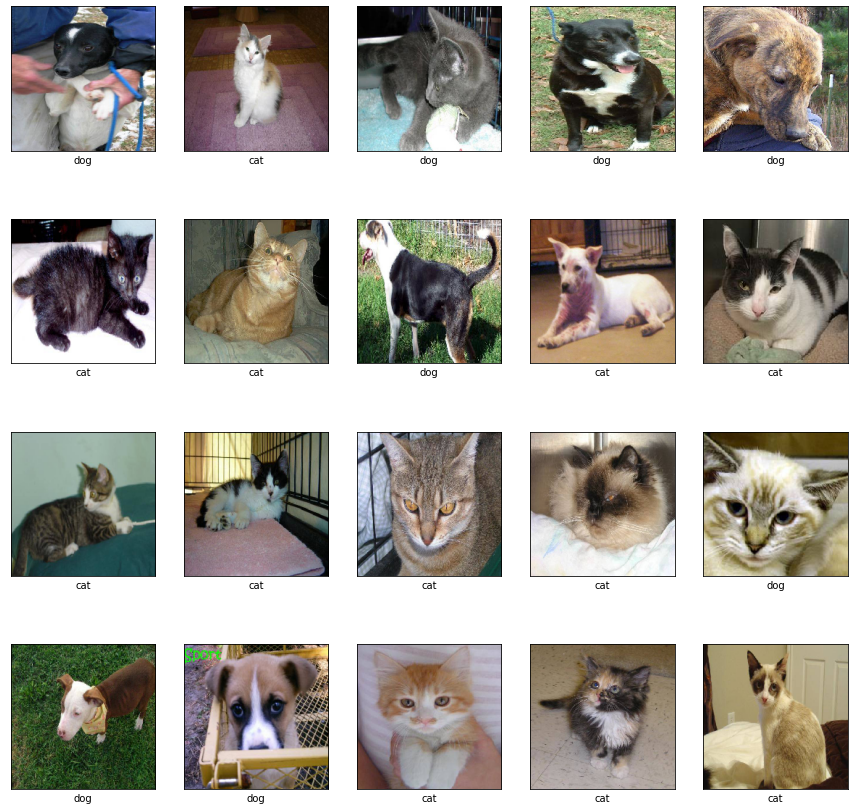

In [58]:
#predictions for test set
prediction = tf.make_tensor_proto(model_final(test_set))
prediction = tf.make_ndarray(prediction)
pyplot.figure(figsize=(15,15))
for i in range(20):
    pyplot.subplot(4,5,i+1)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.grid(False)
    pyplot.imshow(test_set[i].reshape(200,200,3))
    if prediction[i][0] >= 0.5:
        pyplot.xlabel("cat")
    else:
        pyplot.xlabel("dog")
pyplot.show()

## Inception V3

In [4]:
InceptionV3 = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    classifier_activation="softmax",
)

decode = tf.keras.applications.inception_v3.decode_predictions
scaling = tf.keras.applications.inception_v3.preprocess_input

image_preprocessor = Sequential(
  [
   layers.experimental.preprocessing.Resizing(299, 299, name="resizing"),
   layers.Activation(scaling, name='scaling')     
  ],
  name='ImagePreprocessor'
)

In [13]:
from skimage.io import imread

def predict_with_inceptionv3(img=None, url=None, ax=None):
    if url is not None:
        img = imread(url)
        if img.dtype == np.dtype('float64'):
            img = (255*img).astype('int')
        if not ax:
            ax = pyplot
            ax.imshow(img)
            ax.axis('off')
            img = img[None, ...]
            img = image_preprocessor(img)
            prediction = InceptionV3.predict(img)

        return decode(prediction)

[[('n02110806', 'basenji', 0.117082745),
  ('n02106166', 'Border_collie', 0.10597724),
  ('n02113186', 'Cardigan', 0.06000579),
  ('n02091032', 'Italian_greyhound', 0.05765021),
  ('n02106030', 'collie', 0.045240156)]]

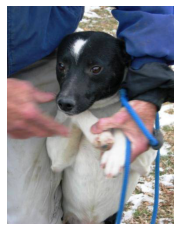

In [17]:
url = 'test1/1.jpg'

predict_with_inceptionv3(url=url)

[[('n02127052', 'lynx', 0.66795254),
  ('n02124075', 'Egyptian_cat', 0.11452823),
  ('n02123045', 'tabby', 0.074738815),
  ('n02123159', 'tiger_cat', 0.0464613),
  ('n02123597', 'Siamese_cat', 0.03595346)]]

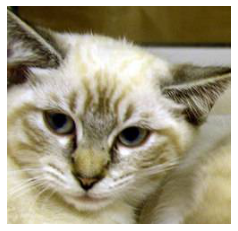

In [20]:
url = 'test1/1001.jpg'

predict_with_inceptionv3(url=url)

[[('n02123045', 'tabby', 0.25642174),
  ('n02124075', 'Egyptian_cat', 0.1536406),
  ('n02883205', 'bow_tie', 0.09391785),
  ('n02123394', 'Persian_cat', 0.026679285),
  ('n02123597', 'Siamese_cat', 0.01689953)]]

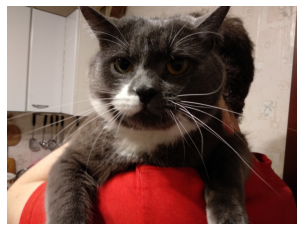

In [24]:
url = 'mace3.jpg'

predict_with_inceptionv3(url=url)

## Transfer learning

In [92]:
# datagen = ImageDataGenerator(rescale=1.0/255.0)

In [86]:
classes = ['cats', 'dogs']

train_it = tf.keras.preprocessing.image_dataset_from_directory('dataset_dogs_vs_cats/train/',
    labels='inferred', label_mode='binary',
    class_names=classes, color_mode='rgb', image_size=(299, 299),
    shuffle=True, seed=400, validation_split=0.2, subset="training")
test_it = tf.keras.preprocessing.image_dataset_from_directory('dataset_dogs_vs_cats/train/',
    labels='inferred', label_mode='binary',
    class_names=classes, color_mode='rgb', image_size=(299, 299),
    shuffle=True, seed=400, validation_split=0.2, subset="validation")

# # prepare iterators
# train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
# 	class_mode='binary', batch_size=32, target_size=(299, 299))
# test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
# 	class_mode='binary', batch_size=32, target_size=(299, 299))

Found 18697 files belonging to 2 classes.
Using 14958 files for training.
Found 18697 files belonging to 2 classes.
Using 3739 files for validation.


In [87]:
inception_layers = InceptionV3.layers
inception_layers.pop()

for layer in inception_layers:
    layer.trainable = False

logit = Sequential([Dense(1, activation='sigmoid', kernel_initializer=HeNormal())])(inception_layers[-1].output)
model = tf.keras.Model(inputs=InceptionV3.inputs, outputs=logit)

pipeline = Sequential([
    layers.Activation(scaling, name='scaling'),
    model
])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [88]:
pipeline.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])

In [89]:
checkpoint_path7 = "training_7/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path7)
cp_callback7 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path7,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir7 = "logs/model7/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback7 = tf.keras.callbacks.TensorBoard(log_dir=log_dir7, histogram_freq=1)

In [93]:
pipeline.fit(train_it, epochs=1, validation_data=test_it, verbose=1, callbacks=[cp_callback7, tensorboard_callback7])

468/468 [==============================] - 531s 1s/step - loss: 0.2120 - accuracy: 0.9400 - auc: 0.9783 - f1: 0.9193 - val_loss: 0.0507 - val_accuracy: 0.9901 - val_auc: 0.9990 - val_f1: 0.9896

Epoch 00001: saving model to training_7\cp.ckpt


In [16]:
# # CREATION OF SMALL TEST SET
# from os import listdir
# from numpy import asarray
# from numpy import save
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# # define location of dataset
# folder = 'test1/'
# photos, labels = list(), list()
# # enumerate files in the directory
# i=0
# for file in listdir(folder):
#     photo = load_img(folder + file, target_size=(299, 299))
#     # convert to numpy array
#     photo = img_to_array(photo)
#     #store
#     photos.append(photo)
#     i += 1
#     if i > 20:
#         break
# # convert to a numpy arrays
# photos = asarray(photos)
# print(photos.shape)
# # save the reshaped photos
# save('test_photos299.npy', photos)

(21, 299, 299, 3)


In [8]:
test_set299 = load('test_photos299.npy') 

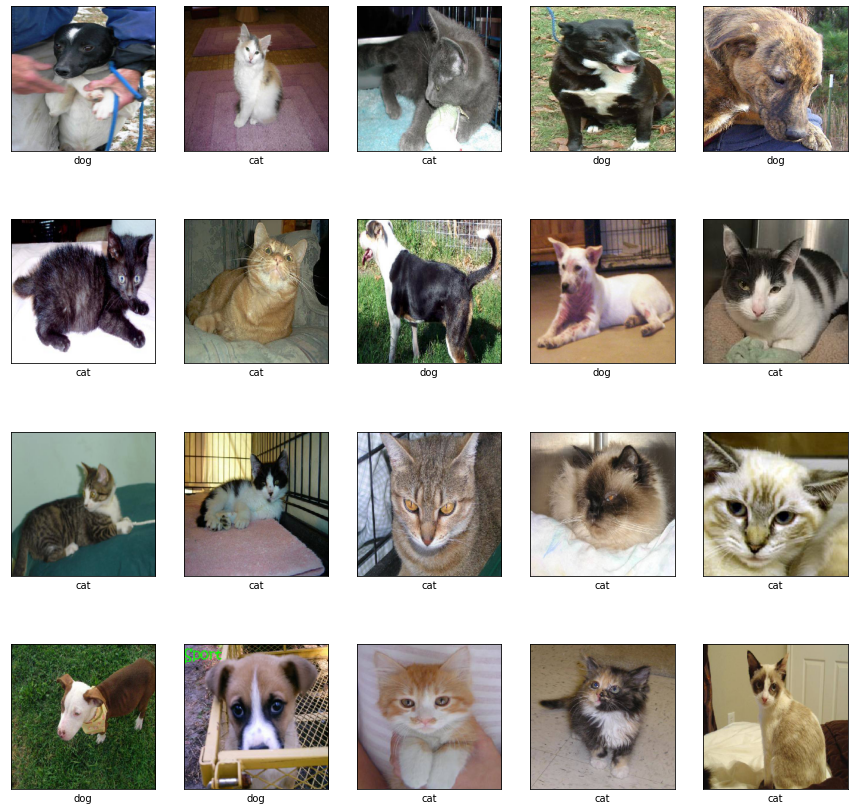

In [111]:
#predictions for test set
prediction = tf.make_tensor_proto(pipeline(test_set299))
prediction = tf.make_ndarray(prediction)
pyplot.figure(figsize=(15,15))
for i in range(20):
    pyplot.subplot(4,5,i+1)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.grid(False)
    pyplot.imshow((test_set299[i]/255).reshape(299,299,3))
    if prediction[i][0] >= 0.5:
        pyplot.xlabel("dog")
    else:
        pyplot.xlabel("cat")
pyplot.show()

In [112]:
pipeline.evaluate(test_it)

117/117 [==============================] - 98s 836ms/step - loss: 0.0507 - accuracy: 0.9901 - auc: 0.9990 - f1: 0.9898


[0.050703372806310654,
 0.9901043176651001,
 0.9989936351776123,
 0.9898256063461304]

In [62]:
def predict_with_transfer(img=None, url=None, ax=None):
    if url is not None:
        img = imread(url)
        if img.dtype == np.dtype('float64'):
            img = (255*img).astype('int')
        if not ax:
            ax = pyplot
            ax.imshow(img)
            ax.axis('off')
            img = img[None, ...]
            img = image_preprocessor(img)
            prediction = pipeline.predict(img)

        return prediction

array([[0.33174932]], dtype=float32)

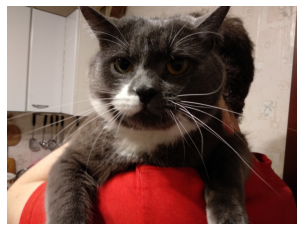

In [115]:
url = 'mace3.jpg'

predict_with_transfer(url=url)

### Model 8 - model 6 + Data Augmentation

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
	width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [122]:
def define_model8():     ### 3 Conv2D + 3 MaxPooling + 1 Dense + Dropout 
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])
    return model

In [123]:
### 4 elu + adadelta
model8 = define_model8()
checkpoint_path8 = "training_8/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path8)
cp_callback8 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path8,
                                                 save_weights_only=True,
                                                 verbose=1)

log_dir8 = "logs/model8/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback8 = tf.keras.callbacks.TensorBoard(log_dir=log_dir8, histogram_freq=1)
#early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [125]:
model8.fit(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=1)

Epoch 1/20
293/293 [==============================] - 388s 1s/step - loss: 0.6984 - accuracy: 0.5206 - auc: 0.5313 - f1: 0.5731 - val_loss: 0.6901 - val_accuracy: 0.5596 - val_auc: 0.6253 - val_f1: 0.6540
Epoch 2/20
293/293 [==============================] - 383s 1s/step - loss: 0.6873 - accuracy: 0.5356 - auc: 0.5586 - f1: 0.5616 - val_loss: 0.6859 - val_accuracy: 0.5791 - val_auc: 0.6234 - val_f1: 0.4293
Epoch 3/20
293/293 [==============================] - 394s 1s/step - loss: 0.6791 - accuracy: 0.5673 - auc: 0.5932 - f1: 0.5762 - val_loss: 0.6768 - val_accuracy: 0.5845 - val_auc: 0.6262 - val_f1: 0.3954
Epoch 4/20
293/293 [==============================] - 395s 1s/step - loss: 0.6735 - accuracy: 0.5721 - auc: 0.6065 - f1: 0.5435 - val_loss: 0.6623 - val_accuracy: 0.6073 - val_auc: 0.6544 - val_f1: 0.5607
Epoch 5/20
293/293 [==============================] - 391s 1s/step - loss: 0.6653 - accuracy: 0.5842 - auc: 0.6219 - f1: 0.5435 - val_loss: 0.6512 - val_accuracy: 0.6078 - val_auc:

In [126]:
model8.save('saved_model/model8_20epochs')

INFO:tensorflow:Assets written to: saved_model/model8_20epochs\assets


In [4]:
model8_restored = tf.keras.models.load_model('saved_model/model8_20epochs', compile=False)
model8_restored.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])

In [9]:
model8_restored.fit(train_it, initial_epoch=20, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=1)

Epoch 21/40
293/293 [==============================] - 362s 1s/step - loss: 0.5716 - accuracy: 0.7019 - auc: 0.7734 - f1: 0.6686 - val_loss: 0.5430 - val_accuracy: 0.7252 - val_auc: 0.8052 - val_f1: 0.7136
Epoch 22/40
293/293 [==============================] - 371s 1s/step - loss: 0.5642 - accuracy: 0.7056 - auc: 0.7797 - f1: 0.6731 - val_loss: 0.5362 - val_accuracy: 0.7271 - val_auc: 0.8089 - val_f1: 0.7011
Epoch 23/40
293/293 [==============================] - 372s 1s/step - loss: 0.5671 - accuracy: 0.7083 - auc: 0.7804 - f1: 0.6756 - val_loss: 0.5301 - val_accuracy: 0.7297 - val_auc: 0.8233 - val_f1: 0.6893
Epoch 24/40
293/293 [==============================] - 368s 1s/step - loss: 0.5529 - accuracy: 0.7142 - auc: 0.7909 - f1: 0.6857 - val_loss: 0.5205 - val_accuracy: 0.7382 - val_auc: 0.8317 - val_f1: 0.6971
Epoch 25/40
293/293 [==============================] - 367s 1s/step - loss: 0.5484 - accuracy: 0.7211 - auc: 0.7972 - f1: 0.6926 - val_loss: 0.5183 - val_accuracy: 0.7363 - val

In [10]:
model8_restored.fit(train_it, initial_epoch=40, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=60, verbose=1)

Epoch 41/60
293/293 [==============================] - 370s 1s/step - loss: 0.4886 - accuracy: 0.7699 - auc: 0.8480 - f1: 0.7572 - val_loss: 0.4634 - val_accuracy: 0.7787 - val_auc: 0.8702 - val_f1: 0.7471
Epoch 42/60
293/293 [==============================] - 381s 1s/step - loss: 0.4853 - accuracy: 0.7655 - auc: 0.8503 - f1: 0.7508 - val_loss: 0.4557 - val_accuracy: 0.7876 - val_auc: 0.8805 - val_f1: 0.7600
Epoch 43/60
293/293 [==============================] - 376s 1s/step - loss: 0.4752 - accuracy: 0.7764 - auc: 0.8567 - f1: 0.7655 - val_loss: 0.4562 - val_accuracy: 0.7828 - val_auc: 0.8760 - val_f1: 0.7528
Epoch 44/60
293/293 [==============================] - 374s 1s/step - loss: 0.4788 - accuracy: 0.7764 - auc: 0.8542 - f1: 0.7630 - val_loss: 0.4384 - val_accuracy: 0.7990 - val_auc: 0.8861 - val_f1: 0.7814
Epoch 45/60
293/293 [==============================] - 375s 1s/step - loss: 0.4740 - accuracy: 0.7796 - auc: 0.8583 - f1: 0.7684 - val_loss: 0.4445 - val_accuracy: 0.7877 - val

In [11]:
model8_restored.fit(train_it, initial_epoch=60, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=80, verbose=1)

Epoch 61/80
293/293 [==============================] - 368s 1s/step - loss: 0.4317 - accuracy: 0.8050 - auc: 0.8847 - f1: 0.7972 - val_loss: 0.4066 - val_accuracy: 0.8145 - val_auc: 0.9002 - val_f1: 0.7985
Epoch 62/80
293/293 [==============================] - 373s 1s/step - loss: 0.4267 - accuracy: 0.8090 - auc: 0.8870 - f1: 0.8020 - val_loss: 0.4011 - val_accuracy: 0.8229 - val_auc: 0.9058 - val_f1: 0.8115
Epoch 63/80
293/293 [==============================] - 379s 1s/step - loss: 0.4259 - accuracy: 0.8105 - auc: 0.8883 - f1: 0.8054 - val_loss: 0.3881 - val_accuracy: 0.8339 - val_auc: 0.9114 - val_f1: 0.8284
Epoch 64/80
293/293 [==============================] - 371s 1s/step - loss: 0.4204 - accuracy: 0.8123 - auc: 0.8908 - f1: 0.8060 - val_loss: 0.3904 - val_accuracy: 0.8256 - val_auc: 0.9119 - val_f1: 0.8089
Epoch 65/80
293/293 [==============================] - 368s 1s/step - loss: 0.4240 - accuracy: 0.8119 - auc: 0.8893 - f1: 0.8067 - val_loss: 0.3985 - val_accuracy: 0.8241 - val

In [12]:
model8_restored.fit(train_it, initial_epoch=80, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=100, verbose=1)

Epoch 81/100
293/293 [==============================] - 386s 1s/step - loss: 0.3960 - accuracy: 0.8248 - auc: 0.9037 - f1: 0.8227 - val_loss: 0.3690 - val_accuracy: 0.8498 - val_auc: 0.9262 - val_f1: 0.8420
Epoch 82/100
293/293 [==============================] - 386s 1s/step - loss: 0.3935 - accuracy: 0.8265 - auc: 0.9056 - f1: 0.8243 - val_loss: 0.3786 - val_accuracy: 0.8331 - val_auc: 0.9238 - val_f1: 0.8144
Epoch 83/100
293/293 [==============================] - 376s 1s/step - loss: 0.3906 - accuracy: 0.8279 - auc: 0.9068 - f1: 0.8261 - val_loss: 0.3680 - val_accuracy: 0.8486 - val_auc: 0.9229 - val_f1: 0.8448
Epoch 84/100
293/293 [==============================] - 361s 1s/step - loss: 0.3913 - accuracy: 0.8297 - auc: 0.9067 - f1: 0.8258 - val_loss: 0.3666 - val_accuracy: 0.8475 - val_auc: 0.9265 - val_f1: 0.8488
Epoch 85/100
293/293 [==============================] - 358s 1s/step - loss: 0.3874 - accuracy: 0.8302 - auc: 0.9084 - f1: 0.8262 - val_loss: 0.3688 - val_accuracy: 0.8523 

In [7]:
model8_restored_2 = tf.keras.models.load_model('saved_model/model8_100epochs', compile=False)
model8_restored_2.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy', 'AUC', f1])

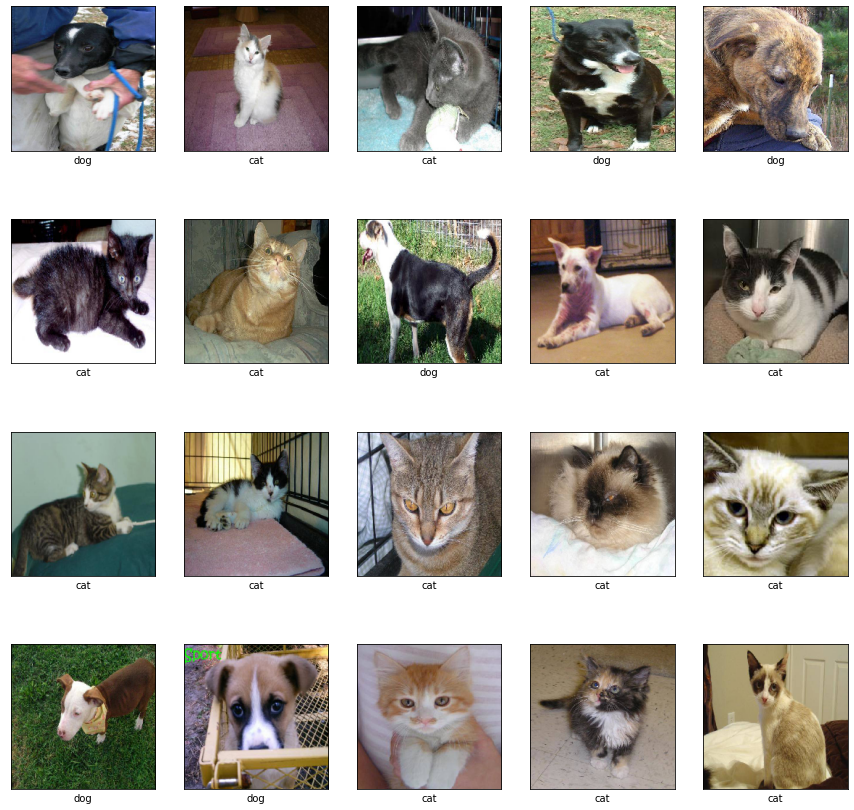

In [12]:
#predictions for test set
prediction = tf.make_tensor_proto(model8_restored_2(test_set))
prediction = tf.make_ndarray(prediction)
pyplot.figure(figsize=(15,15))
for i in range(20):
    pyplot.subplot(4,5,i+1)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.grid(False)
    pyplot.imshow(test_set[i].reshape(200,200,3))
    if prediction[i][0] >= 0.5:
        pyplot.xlabel("dog")
    else:
        pyplot.xlabel("cat")
pyplot.show()